In [1]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import bw2analyzer as ba
import bw_temporalis as bwt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb

In [3]:
import os
from typing import Optional
from pathlib import Path

# Setting the project to the team one on the server

In [4]:
def change_base_directory(base_dir: Path) -> None: 
    assert isinstance(base_dir, Path) and base_dir.is_dir() and os.access(base_dir, os.W_OK) 
    
    bd.projects._base_data_dir = base_dir
    bd.projects.db.change_path(base_dir / "projects.db") 
    bd.projects.set_current("default", update=False) 

In [5]:
tictac_team_dir = Path("/srv/teams/tictac_team") 
change_base_directory(tictac_team_dir) 

bd.projects.set_current("tictac_premise")

In [6]:
bd.projects.current

'tictac_premise'

In [7]:
bd.databases

Databases dictionary with 0 objects

In [8]:
bd.projects.set_current("default")

# Setting the project to one having ecoinvent, from the notebook

In [4]:
bi.restore_project_directory("/srv/data/ecoinvent-3.9-cutoff.tar.gz")

Restoring project backup archive - this could take a few minutes...


ValueError: Project ecoinvent-3.9-cutoff already exists

In [5]:
bd.projects

Brightway2 projects manager with 15 objects:
	Temporalis example project
	USEEIO-1.1
	bw_temporalis example
	default
	dynamic distribution example
	ecoinvent-3.9-cutoff
	ecoinvent=3.9-cutoff
	premise_ei39
	premise_ei39_2
	spreadsheet
	supply chain graph
	supply chain graph_0
	tictac
	tictac spring server
	tictac2
Use `projects.report()` to get a report on all projects.

In [6]:
bd.projects.set_current('premise_ei39')

In [7]:
# bd.projects.migrate_project_25()

In [8]:
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent-3.9-cutoff
	wind-example

In [9]:
ei = bd.Database('ecoinvent-3.9-cutoff')

# Temporal distribution for wind electricity (onshore) in `Europe`, corresponding to `remind SSP2 - 1150` IAM scenario

### Values 

In [10]:
a = np.array([0.79, 1.57, 3.6, 6.03, 8.73, 10.66, 11.27, 11.31])
a = a/np.sum(a) # normalizing the trend in Exajoules to get an actual TD

## Absolute TD

In [11]:
d = np.array([str(2010+k*10)+"-01-01" for k in range(8)])
d = np.array(d,dtype=np.datetime64)
print(d)

['2010-01-01' '2020-01-01' '2030-01-01' '2040-01-01' '2050-01-01'
 '2060-01-01' '2070-01-01' '2080-01-01']


<Axes: xlabel='Date', ylabel='Amount'>

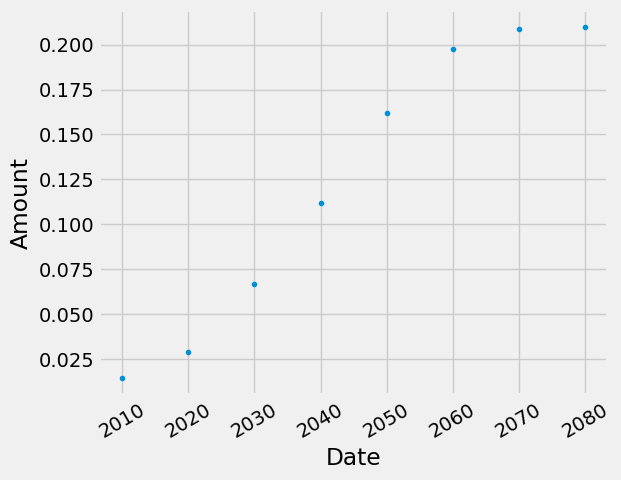

In [12]:
inc_wind_turbine_energy_absolute = bwt.TemporalDistribution(
    date=d,
    amount=a
)
inc_wind_turbine_energy_absolute.graph()

## Relative TD

In [13]:
delta = np.array([np.timedelta64(10*(k+1), 'Y') for k in range(8)])
print(delta)

[10 20 30 40 50 60 70 80]


<Axes: xlabel='Time (seconds)', ylabel='Amount'>

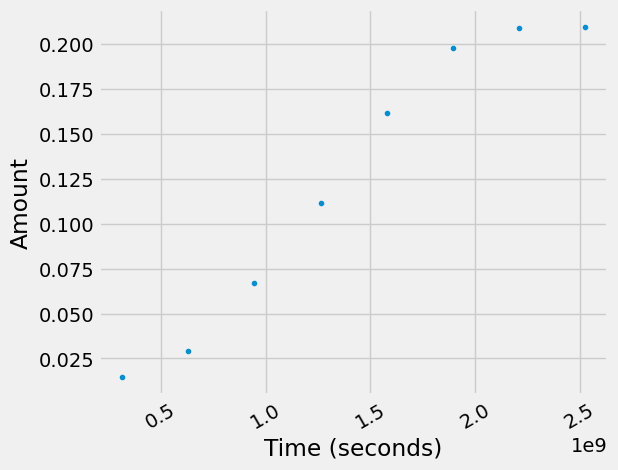

In [14]:
inc_wind_turbine_energy_relative = bwt.TemporalDistribution(
    date=delta,
    amount=a
)
inc_wind_turbine_energy_relative.graph()

# Dummy wind turbine system 

In [15]:
del bd.databases['wind-example']

In [16]:
generated_electricity_over_lifetime = 4.38e9 / 1e3 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=-1,
                    end=1,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=3,
                    # kind = '',
                    # param = 0
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # CO2 emissions corresponding to maintenance
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'electricity-mix'),
                'amount': 200000,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input' : ('wind-example', 'electricity-mix'),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 47060.91it/s]

Vacuuming database 


In [17]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.2787439554172777

In [18]:
tlca = bwt.TemporalisLCA(lca, starting_datetime=np.datetime64(40, 'Y'))

Starting graph traversal
Calculation count: 31


In [19]:
tl = tlca.build_timeline()

In [20]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [21]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

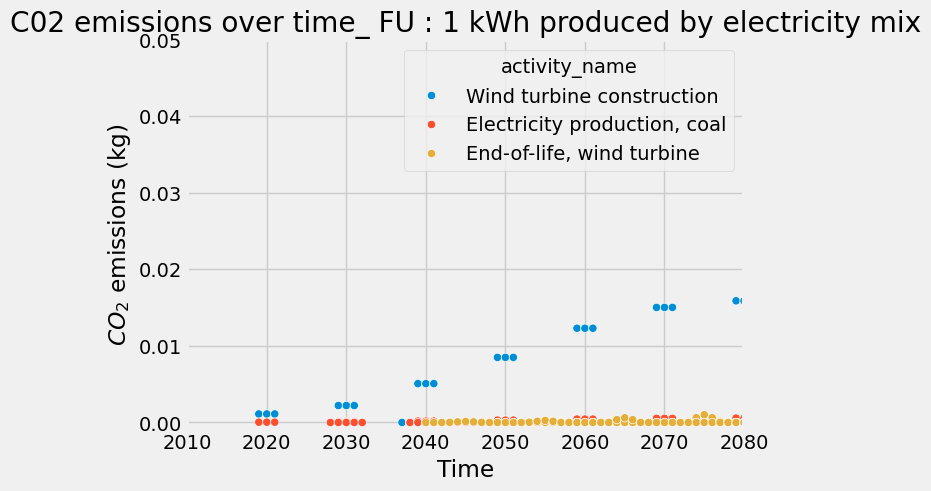

In [22]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y'), xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=0.05)
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Timeline of activities

In [23]:
def build_timeline_processes(tlca, db) :
    ' take as input'
    ' - the result of the graph reversal (given by the "bwt.TemporalisLCA") '
    ' - the name of the database as str (static database, not prospective) '
    ' return a dataframe within the following columns '
    ' - date '
    ' - amount '
    ' - activity (?)'
    ' - database '
    ' - name (of activity) '
    ' - type '
    ' - unit '
    
    tl_activities= tlca.build_timeline(node_timeline=True) #creating timeline for the nodes, not the flows"
    df_tl_act = tl_activities.build_dataframe() # converting the data into dataframe
    df_tl_act=df_tl_act.merge(bd.Database(db).nodes_to_dataframe().rename(columns={"id" : "activity"}), on='activity')
    
    del df_tl_act['flow']
    
    return df_tl_act


In [24]:
df_tl_act = build_timeline_processes(tlca, 'wind-example')
df_tl_act

/opt/tljh/user/envs/autumn_school/lib/python3.11/site-packages/bw_temporalis/lca.py:135: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1.000000e+00,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
1,2019-01-01 04:22:48,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
2,2020-01-01 10:12:00,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
3,2020-12-31 16:01:12,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
4,2028-01-01 08:45:36,3.178041e-08,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
...,...,...,...,...,...,...,...,...
3626,2226-01-01 09:07:12,6.377526e-15,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
3627,2227-01-01 14:56:24,2.467268e-16,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
3628,2228-01-01 20:45:36,5.695356e-18,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
3629,2229-01-01 02:34:48,7.290148e-20,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit


### Example : exchanges timeline for energy activities

In [25]:
df_tl_energy = df_tl_act[df_tl_act['unit']=='kilowatt hour']

In [26]:
df_tl_energy

,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1.000000e+00,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
1,2019-01-01 04:22:48,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
2,2020-01-01 10:12:00,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
3,2020-12-31 16:01:12,1.782706e-04,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
4,2028-01-01 08:45:36,3.178041e-08,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
...,...,...,...,...,...,...,...,...
1615,2198-12-31 19:58:48,1.115600e-08,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,kilowatt hour
1616,2200-01-01 01:48:00,3.305324e-10,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,kilowatt hour
1617,2200-01-01 01:48:00,3.305324e-10,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,kilowatt hour
1618,2201-01-01 07:37:12,3.631540e-12,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,kilowatt hour


In [27]:
df_tl_energy['amount']  = df_tl_energy['amount']*1000

/tmp/ipykernel_1667681/508802167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tl_energy['amount']  = df_tl_energy['amount']*1000


In [28]:
 df_tl_energy.replace({'unit': {'kilowatt hour' :'1e-3 kilowatt hour'}})

,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1.000000e+03,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
1,2019-01-01 04:22:48,1.782706e-01,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
2,2020-01-01 10:12:00,1.782706e-01,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
3,2020-12-31 16:01:12,1.782706e-01,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
4,2028-01-01 08:45:36,3.178041e-05,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
...,...,...,...,...,...,...,...,...
1615,2198-12-31 19:58:48,1.115600e-05,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,1e-3 kilowatt hour
1616,2200-01-01 01:48:00,3.305324e-07,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,1e-3 kilowatt hour
1617,2200-01-01 01:48:00,3.305324e-07,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,1e-3 kilowatt hour
1618,2201-01-01 07:37:12,3.631540e-09,25968,electricity-production-coal,wind-example,"Electricity production, coal",NaN,1e-3 kilowatt hour


(-0.1, 1.0)

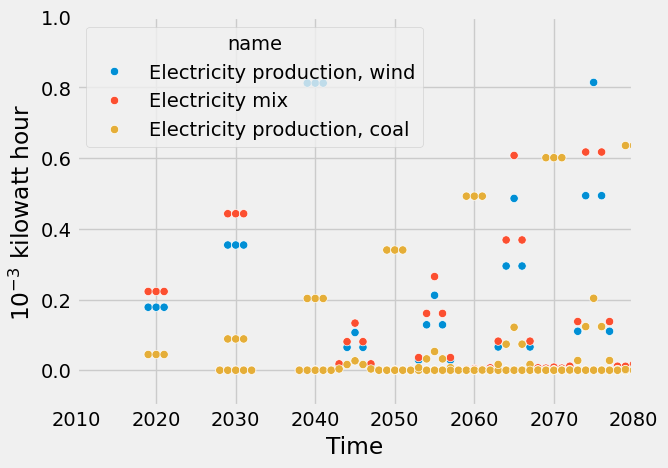

In [29]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'name',
    data = df_tl_energy,
)
axes.set_ylabel("$10^{-3}$ kilowatt hour")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y') ,xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=1, ymin=-0.1)
# axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

# Wind turbine system w/ some ei process

In [33]:
ei.search('market group electricity medium voltage RER')

['market group for electricity, medium voltage' (kilowatt hour, RER, None),
 'market for electricity, medium voltage, aluminium industry' (kilowatt hour, IAI Area, Russia & RER w/o EU27 & EFTA, None)]

In [35]:
act = bd.get_node(name="market group for electricity, medium voltage", location='RER')

In [36]:
act['code']

'17c9d0c2c72446bf59393f60c096a588'

In [67]:
del bd.databases['wind-example']

In [69]:
generated_electricity_over_lifetime = 4.38e9 / 1e3 # Amount of electricity generated by a wind turbine over its lifetime in kWh
share_of_wind_in_electricity_mix = 0.8
LT = 25 # 25 years lifetime of a wind turbine

bd.Database('wind-example').write({
    ('wind-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "unit": "kilogram",
    },
    ('wind-example', "coal"): {
        "type": "emission",
        "name": "coal",
        "unit": "kilogram",
    },
    ('wind-example', 'electricity-mix'): {
        'name': 'Electricity mix',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'electricity-production-coal'),
                'amount': 1-share_of_wind_in_electricity_mix,
                'type': 'technosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-coal'): {
        'name': 'Electricity production, coal',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'coal'),
                'amount': 1,
                'type': 'biosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 0.9,
                'type': 'biosphere',
            },
        ]
    },
    ('wind-example', 'electricity-production-wind'): {
        'name': 'Electricity production, wind',
        'unit': 'kilowatt hour',
        'exchanges': [
            {
                'input': ('wind-example', 'electricity-production-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'operational-wind-turbine'),
                'amount': 1/generated_electricity_over_lifetime,
                'type': 'technosphere',
                'temporal_distribution' : inc_wind_turbine_energy_relative, #we would prefer to use the absolute TD, but for some reason the graph reversal isn't working with it...
            },
            # maybe add maintenance, oil changes, ...
        ]
    },
        ('wind-example', 'operational-wind-turbine'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=-1,
                    end=1,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=3,
                    # kind = '',
                    # param = 0
                ),
            },
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'technosphere',
                'temporal_distribution': bwt.easy_timedelta_distribution(
                    start=20,
                    end=30,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=11,
                    kind = 'normal',
                    param = 0.1
                )
            },
            # CO2 emissions corresponding to maintenance
            # {
            #     'input': ('wind-example', 'CO2'),
            #     'amount': 100,
            #     'type': 'biosphere',
            # }
        ]
    },
    ('wind-example', 'wind-turbine-construction'): {
        'name': 'Wind turbine construction',
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'wind-turbine-construction'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('ecoinvent-3.9-cutoff', act['code']),
                'amount': 2e5,
                'type': 'technosphere',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e6,
                'type': 'biosphere',
            } #taking into account CO2 of machine and materials, not just operational energy
        ]
    },
    ('wind-example', 'eol-wind'): {
        'name': "End-of-life, wind turbine",
        'unit': 'unit',
        'exchanges': [
            {
                'input': ('wind-example', 'eol-wind'),
                'amount': 1,
                'type': 'production',
            },
            {
                'input': ('wind-example', 'CO2'),
                'amount': 1e5,
                'type': 'biosphere',
            }, #taking into account CO2 of machines and materials, not just operational energy
            {
                'input' : ('ecoinvent-3.9-cutoff', act['code']),
                'amount': 1e5,
                'type': 'technosphere',
            }
        ]
    },
})

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 8/8 [00:00<00:00, 117734.85it/s]

Vacuuming database 


In [70]:
lca = bc.LCA({('wind-example', 'electricity-production-wind'): 1}, ("GWP", "wind-example"))
lca.lci()
lca.lcia()
lca.score

0.25114154738048455

In [71]:
tlca = bwt.TemporalisLCA(lca, starting_datetime=np.datetime64(40, 'Y'))

Starting graph traversal
Calculation count: 3


In [72]:
tl = tlca.build_timeline()

In [73]:
df = tl.build_dataframe()
df = tl.add_metadata_to_dataframe(['wind-example'])

In [74]:
bd.get_activity(id=25972)

'End-of-life, wind turbine' (unit, None, None)

In [75]:
df2  = bd.Database('wind-example').nodes_to_dataframe()

Text(0.5, 1.0, 'C02 emissions over time_ FU : 1 kWh produced by electricity mix')

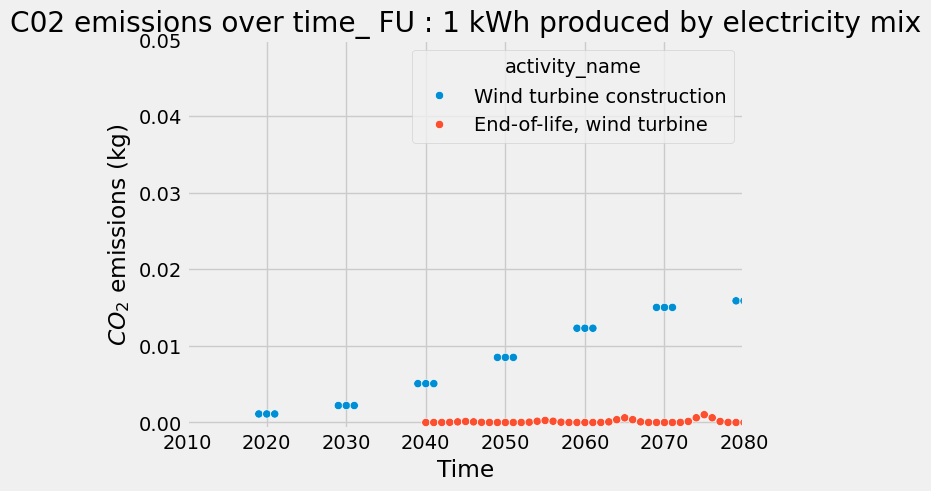

In [76]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'activity_name',
    data = df.merge(
        df2.rename(columns={'id' : 'activity'}), on='activity'
    )
)
axes.set_ylabel("$CO_{2}$ emissions (kg)")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y'), xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=0.05)
axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service

In [77]:
df_tl_energy_w_ei = build_timeline_processes(tlca, 'wind-example')
df_tl_energy_w_ei

/opt/tljh/user/envs/autumn_school/lib/python3.11/site-packages/bw_temporalis/lca.py:135: UserWarning: This functionality is experimental, and will change.
You have been warned.
  warnings.warn(


,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1.000000e+00,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,kilowatt hour
1,2019-01-01 04:22:48,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
2,2020-01-01 10:12:00,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
3,2020-12-31 16:01:12,1.114191e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
4,2028-12-31 14:34:48,2.214279e-09,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
...,...,...,...,...,...,...,...,...
109,2116-01-01 16:55:12,1.157922e-08,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
110,2116-12-31 22:44:24,2.583674e-09,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
111,2118-01-01 04:33:36,2.120808e-10,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
112,2119-01-01 10:22:48,6.404287e-12,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit


In [78]:
df_tl_energy_w_ei['amount']  = df_tl_energy['amount']*1000

In [79]:
 df_tl_energy_w_ei.replace({'unit': {'kilowatt hour' :'1e-3 kilowatt hour'}})

,date,amount,activity,code,database,name,type,unit
0,2010-01-01 00:00:00,1000000.000000,25969,electricity-production-wind,wind-example,"Electricity production, wind",NaN,1e-3 kilowatt hour
1,2019-01-01 04:22:48,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
2,2020-01-01 10:12:00,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
3,2020-12-31 16:01:12,178.270616,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
4,2028-12-31 14:34:48,0.031780,25971,wind-turbine-construction,wind-example,Wind turbine construction,NaN,unit
...,...,...,...,...,...,...,...,...
109,2116-01-01 16:55:12,0.163080,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
110,2116-12-31 22:44:24,0.000866,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
111,2118-01-01 04:33:36,0.004846,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit
112,2119-01-01 10:22:48,2405.525022,25972,eol-wind,wind-example,"End-of-life, wind turbine",NaN,unit


(-0.1, 1.0)

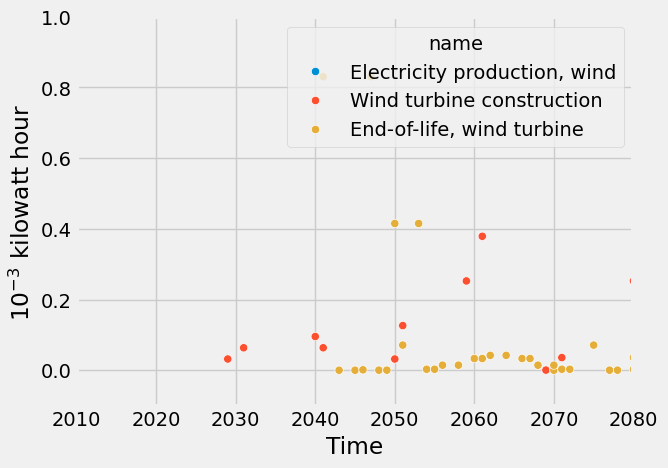

In [80]:
axes = sb.scatterplot(
    x = "date",
    y = 'amount',
    hue = 'name',
    data = df_tl_energy_w_ei,
)
axes.set_ylabel("$10^{-3}$ kilowatt hour")
axes.set_xlabel("Time")
axes.set_xlim(xmin=np.datetime64(40, 'Y') ,xmax=np.datetime64(110, 'Y'))
axes.set_ylim(ymax=1, ymin=-0.1)
# axes.set_title("C02 emissions over time_ FU : 1 kWh produced by electricity mix") #right after being put in service